<a href="https://colab.research.google.com/github/DurdenTyler2008/University-of-AI/blob/main/%D0%93%D0%B5%D0%BD%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Написать сверточную сеть с помощью генетического алкоритма (подобрать оптимальные параметры)


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = psutil.Process(os.getpid())
print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print("GPU Model: ", gpu.name)

Gen RAM Free: 12.6 GB  | Proc size: 408.9 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB
GPU Model:  Tesla T4


### Загрузки:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils                                              # Для to_categorical
import numpy as np 
from keras.optimizers import Adam 
from keras.models import Sequential, Model                                      # Два варианты моделей
from keras.layers import concatenate,Reshape, Input,Conv2DTranspose, Lambda, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation, GlobalMaxPooling1D, UpSampling1D#Стандартные слои
from keras.losses import MAE
from google.colab import files                                                  # Загрузка файлов
from sklearn.preprocessing import StandardScaler, MinMaxScaler                  # Нормировщики
from keras.preprocessing.sequence import TimeseriesGenerator                    # Для генерации выборки временных рядов
import keras.backend as K
import random as random
from PIL import Image                                                           # Импортируем одель Image для обработки изображений
import time
from tensorflow.keras.utils import plot_model
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Подбор архитектуры свёрточной сети

###Загрузка базы:

In [ ]:
base_data = pd.read_csv('/content/drive/My Drive/traff.csv',header=None)

In [ ]:
print(base_data.head)
print("Размер:", base_data.shape)

<bound method NDFrame.head of                0          1
0       1/1/2017  22,226.00
1       1/2/2017  29,593.00
2       1/3/2017  31,726.00
3       1/4/2017  32,684.00
4       1/5/2017  31,820.00
...          ...        ...
1090  12/27/2019  29,801.00
1091  12/28/2019  34,913.00
1092  12/29/2019  37,665.00
1093  12/30/2019  32,643.00
1094  12/31/2019  28,212.00

[1095 rows x 2 columns]>
Размер: (1095, 2)


In [ ]:
data = base_data.iloc[:,1]

In [ ]:
d = data
print("Сколько есть записей:", len(d))              
print("Длинна одной строки данных:", len(d.iloc[0]))      
print("Пример первой строки данных:", d.iloc[0])            

Сколько есть записей: 1095
Длинна одной строки данных: 9
Пример первой строки данных: 22,226.00


In [ ]:
data = np.array(data) 
for i in range(len(data)):
    data[i] = float(data[i].replace(',',''))

In [ ]:
data[21]

30137.0

###Функция загрузки данных:

In [ ]:
xLen = 60                                                   # Анализируем по 300 прошедшим точкам 
valLen = 300                                                # Используем 300 записей для проверки
trainLen = data.shape[0]-valLen                             # Размер тренировочной выборки

# Делим данные на тренировочную и тестовую выборки:

Train,Test = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1))

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке:

Scaler = MinMaxScaler()
Scaler.fit(Train)
Train = Scaler.transform(Train)
Test = Scaler.transform(Test)


# Создаю генератор Train:
trainDataGen = TimeseriesGenerator(Train, Train,length=xLen, sampling_rate=1, batch_size=20)                

# Создаю генератор Test"
testDataGen = TimeseriesGenerator(Test, Test, length=xLen, sampling_rate=1, batch_size=20)

###Функции для отображения результатов **getPred**:
- Функция рассчитывает результаты прогнозирования сети
- В аргументы принимает сеть (currModel) и проверочную выборку
- Выдаёт результаты предсказания predVal
- И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)

In [ ]:
def getPred(currModel, xVal, yVal, yScaler):

    predVal = yScaler.inverse_transform(currModel.predict(xVal))      # Предсказываем ответ сети по проверочной выборке
    yValUnscaled = yScaler.inverse_transform(yVal)                    # И возвращаем исходны масштаб данных, до нормализации
    
    return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled):         # Функция визуализирует графики, что предсказала сеть и какие были правильные ответы

#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем

    plt.plot(predVal[start:start+step, channel], label='Прогноз')
    plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')
    plt.xlabel('Время')
    plt.ylabel('Значение Close')
    plt.legend()
    plt.show()
  

def correlate(a, b):                                                  # Функция рассчёта корреляции дух одномерных векторов

    ma = a.mean()                                                     # Среднее значение первого вектора
    mb = b.mean()                                                     # Среднее значение второго вектора
    mab = (a*b).mean()                                                # Среднее значение произведения векторов
    sa = a.std()                                                      # Среднеквадратичное отклонение первого вектора
    sb = b.std()                                                      # Среднеквадратичное отклонение второго вектора
    
    #Рассчитываем корреляцию
    val = 0
    if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
    return val


def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):  # Функция рисует корреляцию прогнозированного сигнала с правильным

#Смещая на различное количество шагов назад
#Для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
#showGraf - показываем график или нет
#returnData - возвращаем массивы автокорреляции или нет


    for ch in channels:                                   # Проходим по всем каналам
      corr = []                                           # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
      yLen = yValUnscaled.shape[0]                        # Запоминаем размер проверочной выборки

      for i in range(corrSteps):                          # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
          # Получаем сигнал, смещённый на i шагов назад
          # predVal[i:, ch]
          # Сравниваем его с верными ответами, без смещения назад
          # yValUnscaled[:yLen-i,ch]
          # Рассчитываем их корреляцию и добавляем в лист
          corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

      own_corr = []                                       # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      for i in range(corrSteps):                          # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
          # Получаем сигнал, смещённый на i шагов назад
          # predVal[i:, ch]
          # Сравниваем его с верными ответами, без смещения назад
          # yValUnscaled[:yLen-i,ch]
          # Рассчитываем их корреляцию и добавляем в лист
          own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

      if showGraf:                                        # Отображаем график коррелций для данного шага,eсли нужно показать график
        plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
        plt.plot(own_corr, label='Эталон')

    if showGraf:                                          #Если нужно показать график
      plt.xlabel('Время')
      plt.ylabel('Значение')
      plt.legend()
      plt.show()

    if returnData:                                        #Если нужно вернуть массивы автокорреляции
      return corr, own_corr

###Генерируем проверочную выборку:
- Создаю генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки

In [ ]:
DataGen = TimeseriesGenerator(Test, Test,length=xLen, sampling_rate=1,
                               batch_size=len(Test)) # Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
    xVal.append(i[0])
    yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Подбор линейной архитектуры:



**Входной слой**

*   0 - делаем ли нормализацию
*   1 - размер первого свёрточного слоя
*   2 - ядро первого свёрточного слоя 
*   3 - функция активации первого слоя
*   4 - делаем ли MaxPooling0
*   5 - размер MaxPooling0

**Первый скрытый слой**

*   6 - Делаем ли второй сверточный слой
*   7 - размер второго сверточного слоя
*   8 - ядро второго сверточного слоя
*   9 - делаем ли MaxPooling1
*   10 - размер MaxPooling1
*   11 - функция активации

**Второй скрытый слой**

*   12 - Делаем ли третий сверточный слой
*   13 - размер третьего сверточного слоя
*   14 - ядро третьего сверточного слоя
*   15 - делаем ли MaxPooling2
*   16 - размер MaxPooling2
*   17 - функция активации 
----
*   18 - функция активации предпоследнего слоя
*   19 - функция активации выходного слоя
----
**Третий(предпоследний) скрытый слой**

*   20 - делаем ли нормализацию 
*   21 - размер полносвязного слоя

In [103]:
#Создаём сеть (net - список параметров)
def createConvNet(net):

  model = Sequential()             # Создаем моель Sequential
  
  makeFirstNormalization = net[0]  # Делаем ли нормализацию в начале
  firstConvSize = 2 ** net[1]      # Размер первого вёрточного слоя
  firstConvKernel = net[2]         # Ядро первого свёрточного слоя
  activation0 = net[3]             # Функция активации входного слоя
  makeMaxPooling0 = net[4]         # Делаем ли maxpooling для нулевого слоя
  maxPoolingSize0 = net[5]         # Размер MaxPooling

  makeSecondConv = net[6]          # Делаем ли второй свёрточный слой
  secondConvSize = 2 ** net[7]     # Размер второго свёрточного слоя
  secondConvKernel = net[8]        # Ядро второго свёрточного слоя
  makeMaxPooling1 = net[9]         # Делаем ли MaxPooling
  maxPoolingSize1 = net[10]        # Размер MaxPooling
  activation1 = net[11]            # Функция активации

  makeThirdConv = net[12]          # Делаем ли второй свёрточный слой
  thirdConvSize = 2 ** net[13]     # Размер второго свёрточного слоя
  thirdConvKernel = net[14]        # Ядро второго свёрточного слоя
  makeMaxPooling2 = net[15]        # Делаем ли MaxPooling
  maxPoolingSize2 = net[16]        # Размер MaxPooling
  activation2 = net[17]            # Функция активации

  activation3 = net[18]            # Функция активации для 
  activation4 = net[19]            # Функция активации для последнего слоя

  makeSecondNormalization = net[20] # Делаем ли финальную нормализацию
  denseSize = 2 ** net[21]          # Размер полносвязного слоя

  activation_list = ['linear','relu','tanh','softmax','sigmoid'] 

  if (makeFirstNormalization):      # Если делаем нормализацию в начале

    # Добавляем слой BatchNormalization
    model.add(BatchNormalization(input_shape=(xLen, 1))) 

    # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
    model.add(Conv1D(firstConvSize, firstConvKernel, activation=activation_list[activation0], padding='same')) 
  else:

    # Добавляем Conv1D-слой с firstConvSize нейронами и ядром (firstConvKernel)
    model.add(Conv1D(firstConvSize, firstConvKernel, input_shape=(xLen, 1), activation=activation_list[activation0], padding='same')) 

  if makeMaxPooling0:               # Если делаем maxpooling
    model.add(MaxPooling1D(maxPoolingSize0))


  if (makeSecondConv):              # Если делаем второй свёрточный слой
    # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
    model.add(Conv1D(secondConvSize, secondConvKernel, activation=activation_list[activation1], padding='same')) 
    
    if (makeMaxPooling1):           # Если делаем MaxPooling
      # Добавляем слой MaxPooling1D с размером (maxPoolingSize)
      model.add(MaxPooling1D(pool_size=maxPoolingSize1)) 


  if (makeThirdConv):               # Если делаем второй свёрточный слой
    # Добавляем Conv1D-слой с secondConvSize нейронами и ядром (secondConvKernel)
    model.add(Conv1D(thirdConvSize, thirdConvKernel, activation=activation_list[activation2], padding='same')) 

    if (makeMaxPooling2):           # Если делаем MaxPooling
      # Добавляем слой MaxPooling1D с размером (maxPoolingSize, maxPoolingSize)
      model.add(MaxPooling1D(pool_size=maxPoolingSize2)) 
          
  if (makeSecondNormalization):     # Если делаем финальную нормализацию
    model.add(BatchNormalization()) # Добавляем слой BatchNormalization
  
  model.add(Flatten())              # Добавляем слой Flatten

  model.add(Dense(denseSize, activation=activation_list[activation3])) # Добавляем слой Dense с denseSize нейронами
  model.add(Dense(1, activation=activation_list[activation4]))         # Добавляем Dense-слой с softmax-активацией и 10 нейронами
  
  return model                                                         # Возвращаем модель

'''
  Функция вычисления результата работы сети
'''

def evaluateNet(net, ep, verb):
  val = 0
  time.time()
  model = createConvNet(net)                                # Создаем модель createConvNet

  # Компилируем модель
  model.compile(optimizer=Adam(lr=1e-4), loss='mse')

  history = model.fit_generator(trainDataGen, epochs=5, verbose=verb, validation_data=testDataGen)
    
  val = history.history["val_loss"][-1]                     # Возвращаем точность на проверочной выборке с последней эпохи
  
  return val, model                                         # Возвращаем точность

'''
  Функция создания списка случайных параметров
'''
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) #Делаем или нет нормализацию
  net.append(random.randint(3,10)) #Первый свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) #Ядро первого свёрточного слоя от 3 до 7
  net.append(random.randint(0,4)) #Функция активации первого слоя
  net.append(random.randint(0,1)) #Делаем ли MaxPooling
  net.append(random.randint(2,3)) #Размер MaxPooling

  net.append(random.randint(0,4)) # Сколько делаем еще сверточных слоев
  net.append(random.randint(3,12)) # Второй свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1)) # Делаем ли MaxPooling
  net.append(random.randint(2,3)) # Размер MaxPooling
  net.append(random.randint(0,4)) # Функция активации второго слоя

  net.append(random.randint(0,4)) # Сколько делаем еще сверточных слоев
  net.append(random.randint(3,10)) # Второй свёрточный слой от 8 до 64 нейронов
  net.append(random.randint(3,7)) # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1)) # Делаем ли MaxPooling
  net.append(random.randint(2,3)) # Размер MaxPooling
  net.append(random.randint(0,4)) # Функция активации второго слоя

  net.append(random.randint(0,4)) # Функция активации предпоследнего dense слоя
  net.append(random.randint(0,2)) # Функция активации последнего слоя

  net.append(random.randint(0,1)) # Делаем ли финальную нормализацию слой
  net.append(random.randint(3,6)) # Размер полносвязного слоя от 8 до 64
  
  return net

In [104]:
n = 20              # Общее число ботов
nsurv = 10          # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv    # Количество новых (столько новых ботов создается)
l = 22              # Размер бота
epohs = 12          # количество эпох

mut = 0.09          # коэфициент мутаций

popul = []          # Массив популяции
val = []            # Одномерный массив значений этих ботов

#Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet())
  
for it in range(epohs):                 # Пробегаем по всем эпохам
  val = []                              # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):                    # Пробегаем в цикле по всем ботам 
    bot = popul[i]                      # Берем очередного бота
    f, model_sum = evaluateNet(bot, 3, 0) # Вычисляем точность текущего бота
    val.append(f)                       # Добавляем полученное значение в список val
  
  sval = sorted(val, reverse=0)         # Сортируем val
  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time, " ", sval[0:5],popul[:5]) 
  
  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):                 # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
    newbot = []                         # Создаем пустой список под значения нового бота    
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(l):                  # Пробегаем по всей длине размерности (784)      
      x = 0      
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      
      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]
        
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul                      # Записываем в popul новую посчитанную популяцию

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


0 53.886009216308594   [0.029043199494481087, 0.037332575768232346, 0.07112539559602737, 0.07739441096782684, 0.09824471920728683] [[1, 4, 3, 1, 1, 3, 2, 8, 7, 1, 3, 1, 4, 8, 5, 1, 3, 1, 0, 0, 1, 5], [0, 4, 7, 4, 1, 2, 4, 12, 5, 1, 3, 2, 4, 7, 3, 1, 3, 0, 3, 1, 1, 4], [1, 4, 5, 0, 1, 2, 2, 7, 4, 0, 2, 0, 2, 10, 5, 1, 3, 0, 4, 1, 0, 5], [1, 3, 7, 1, 0, 2, 2, 3, 7, 1, 2, 3, 4, 3, 6, 1, 2, 1, 4, 1, 1, 6], [1, 4, 4, 1, 0, 2, 0, 4, 7, 1, 2, 0, 4, 9, 7, 1, 2, 1, 3, 1, 1, 3]]
1 63.06512713432312   [0.029817884787917137, 0.050199177116155624, 0.05971159040927887, 0.08483923971652985, 0.08597403019666672] [[1, 3, 3, 4, 0, 2, 1, 11, 7, 0, 3, 1, 0, 9, 3, 1, 2, 2, 0, 2, 0, 5], [0, 7, 5, 0, 0, 2, 3, 5, 5, 1, 3, 4, 0, 5, 5, 0, 2, 0, 0, 2, 0, 6], [1, 10, 7, 4, 1, 2, 2, 12, 4, 1, 3, 0, 4, 6, 7, 0, 3, 4, 4, 1, 0, 5], [1, 10, 3, 3, 1, 2, 0, 6, 7, 1, 2, 4, 0, 6, 5, 1, 2, 0, 0, 0, 0, 4], [1, 3, 6, 4, 1, 3, 0, 11, 4, 0, 2, 2, 0, 9, 5, 0, 3, 2, 1, 2, 0, 6]]
2 30.919979333877563   [0.01776205748319626, 0.034

In [105]:
print("Геномы лучших ботов по эпохам:", "\n", popul) 

Геномы лучших ботов по эпохам: 
 [[0, 7, 3, 0, 0, 3, 3, 12, 7, 1, 2, 0, 4, 5, 5, 0, 2, 2, 0, 0, 0, 5], [0, 7, 5, 0, 0, 3, 3, 12, 7, 1, 3, 0, 4, 10, 4, 0, 3, 0, 0, 0, 0, 5], [0, 7, 5, 0, 0, 3, 3, 6, 5, 1, 2, 1, 4, 9, 5, 0, 2, 0, 0, 1, 0, 4], [0, 7, 3, 0, 0, 2, 3, 11, 5, 1, 3, 1, 4, 9, 5, 0, 2, 0, 0, 0, 0, 4], [0, 7, 3, 0, 0, 2, 3, 11, 7, 1, 3, 0, 4, 10, 6, 0, 3, 0, 0, 0, 0, 5], [0, 7, 7, 0, 0, 3, 3, 12, 5, 1, 3, 1, 4, 10, 4, 0, 3, 0, 2, 0, 0, 5], [0, 7, 3, 0, 0, 3, 3, 12, 7, 1, 3, 1, 4, 9, 5, 0, 2, 0, 0, 0, 0, 4], [0, 7, 3, 0, 0, 2, 3, 11, 7, 1, 3, 1, 4, 9, 5, 0, 2, 0, 0, 0, 0, 4], [0, 7, 5, 0, 0, 3, 3, 6, 6, 1, 3, 1, 4, 9, 5, 0, 2, 0, 0, 0, 0, 4], [0, 7, 5, 0, 0, 3, 3, 9, 7, 1, 3, 0, 4, 10, 5, 1, 3, 0, 0, 0, 0, 5], [0, 7, 5, 0, 0, 2, 3, 12, 7, 1, 3, 0, 4, 10, 5, 0, 3, 0, 0, 0, 0, 5], [0, 4, 3, 0, 0, 3, 3, 6, 6, 1, 2, 1, 4, 5, 5, 0, 2, 2, 0, 1, 0, 4], [0, 7, 3, 0, 0, 2, 3, 11, 7, 1, 3, 0, 4, 9, 5, 1, 3, 0, 0, 0, 0, 4], [0, 7, 3, 0, 0, 3, 3, 9, 7, 1, 3, 0, 4, 9, 5, 1, 3, 0, 0, 0, 0, 5], 

In [106]:
model = createConvNet(popul[0])
model.summary()


Model: "sequential_743"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1666 (Conv1D)         (None, 60, 128)           512       
_________________________________________________________________
conv1d_1667 (Conv1D)         (None, 60, 4096)          3674112   
_________________________________________________________________
max_pooling1d_600 (MaxPoolin (None, 30, 4096)          0         
_________________________________________________________________
conv1d_1668 (Conv1D)         (None, 30, 32)            655392    
_________________________________________________________________
flatten_743 (Flatten)        (None, 960)               0         
_________________________________________________________________
dense_1486 (Dense)           (None, 32)                30752     
_________________________________________________________________
dense_1487 (Dense)           (None, 1)              

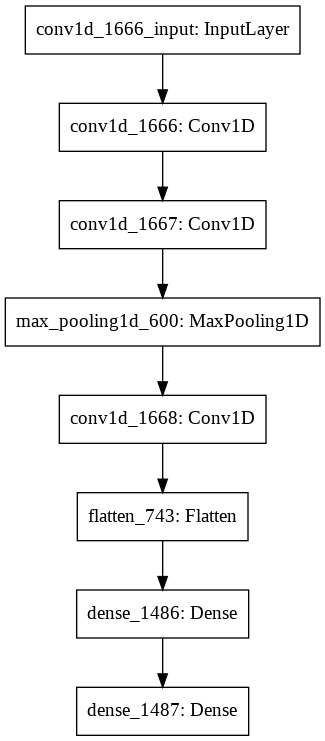

In [107]:
plot_model(model)

In [108]:
model.compile(optimizer=Adam(lr=1e-4), loss='mse')
history = model.fit_generator(trainDataGen, epochs=50, validation_data=testDataGen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 25ms/step - loss: 0.0723 - val_loss: 0.0082
Epoch 2/50
37/37 [==============================] - 1s 19ms/step - loss: 0.0092 - val_loss: 0.0152
Epoch 3/50
37/37 [==============================] - 1s 19ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 4/50
37/37 [==============================] - 1s 19ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 5/50
37/37 [==============================] - 1s 19ms/step - loss: 0.0034 - val_loss: 0.0052
Epoch 6/50
37/37 [==============================] - 1s 19ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 7/50
37/37 [==============================] - 1s 19ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 8/50
37/37 [==============================] - 1s 19ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 9/50
37/37 [==============================] - 1s 19ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 10/50
37/37 [==============================] - 1s 20ms/step - loss: 0.0032 - val_loss: 0.0053
Epoch 11/

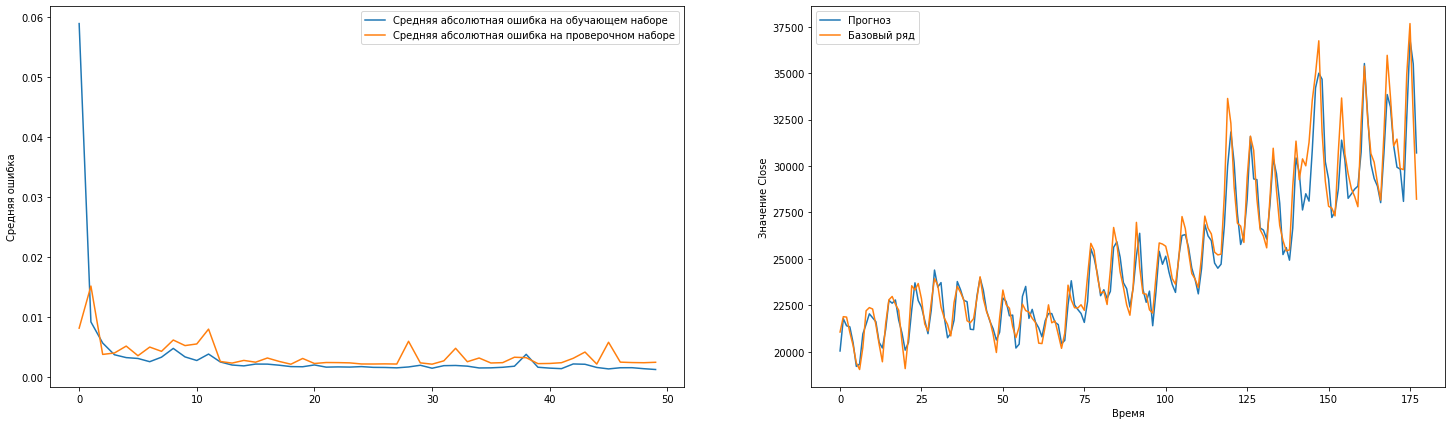

In [109]:
plt.figure(figsize=(25, 7))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()

plt.subplot(1, 2, 2)
currModel = model 
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) 
showPredict(0, 400, 0, predVal, yValUnscaled)

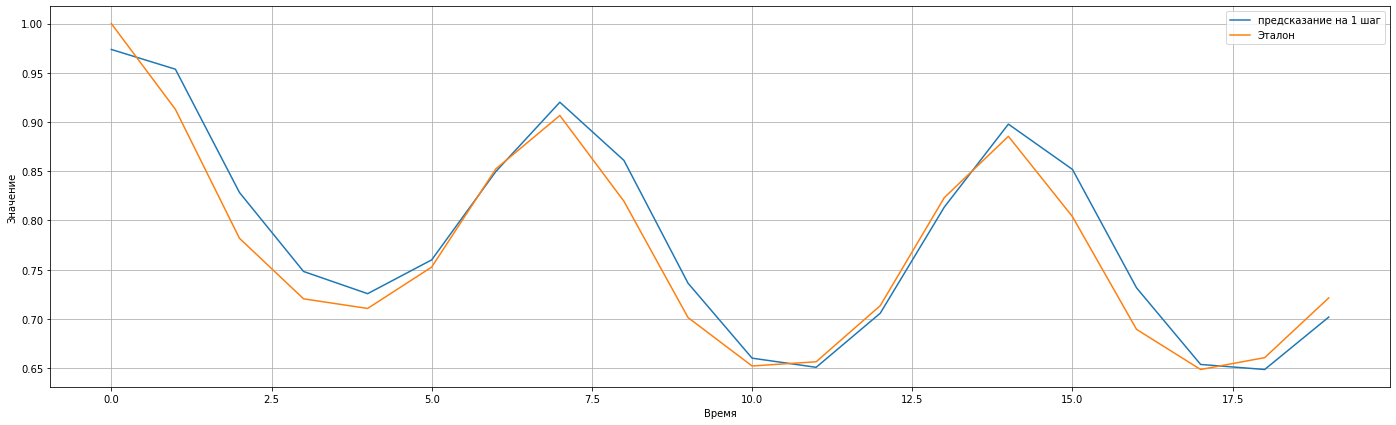

In [110]:
plt.figure(figsize=(24, 7))
plt.grid()
autoCorr([0], 20, predVal, yValUnscaled)

In [ ]:
# изменение параметров в функции createRandomNet принципиально результат не иизменило 

In [ ]:
#------------------------------------------------------------------------------------

# Подбор нелинейной архитектуры functional AI:





**БЛОК 1**
*   0 - делаем ли нормализацию
*   1 - размер MaxPooling для всех слоев

*   2 - размер первого свёрточного слоя
*   3 - ядро первого свёрточного слоя
*   4 - функция активации первого слоя

**БЛОК 2**
*   5 - делаем ли второй свёрточный слой
*   6 - размер второго свёрточного слоя
*   7 - ядро второго свёрточного слоя
*   8 - делаем ли MaxPooling
*   9 - функция активации второго слоя 

**БЛОК 3**
*   10 - делаем ли второй свёрточный слой
*   11 - размер второго свёрточного слоя
*   12 - ядро второго свёрточного слоя
*   13 - делаем ли MaxPooling
*   14 - функция активации второго слоя 

**БЛОК 4**
*   15 - делаем ли второй свёрточный слой
*   16 - размер второго свёрточного слоя
*   17 - ядро второго свёрточного слоя
*   18 - делаем ли MaxPooling
*   19 - функция активации второго слоя 

**БЛОК 5**
*   20 - делаем ли второй свёрточный слой
*   21 - размер второго свёрточного слоя
*   22 - ядро второго свёрточного слоя
*   23 - делаем ли MaxPooling
*   24 - функция активации второго слоя 

**БЛОК 6**
*   25 - делаем ли нормализацию перед полносвязным слоем
*   26 - делаем ли полносвязный слой
*   27 - размер полносвязного слоя

In [114]:

def createConvNet(net):
  
  makeFirstNormalization = net[0] # Делаем ли нормализацию в начале
  maxPoolKernel = net[1]          # Ядро пуллинга

  firstConvSize = 2 ** net[2]     # Размер первого cвёрточного слоя
  firstConvKernel = net[3]        # Ядро первого свёрточного слоя
  activation1 = net[4]            # Функция активации первого слоя

  makeConv2 = net[5]              # Делаем ли второй сверточный слой
  secondConvSize = 2 ** net[6]    # Ядро второго свёрточного слоя
  secondConvKernel = net[7]       # Размер второго свёрточного слоя
  makePool2 = net[8]              # Делаем ли пуллинг?
  activation2 = net[9]            # Функция активации второго слоя

  makeConv3 = net[10]             # Делаем ли  сверточный слой
  thirdConvSize = 2 ** net[11]    # Ядро третьего свёрточного слоя
  thirdConvKernel = net[12]       # Размер третьего свёрточного слоя
  makePool3 = net[13]             # Делаем ли пуллинг?
  activation3 = net[14]           # Функция активации третьего слоя

  makeConv4 = net[15]             # Делаем ли  сверточный слой
  fourthConvSize = 2 ** net[16]   # Ядро четвертого свёрточного слоя
  fourthConvKernel = net[17]      # Размер четвертого свёрточного слоя
  makePool4 = net[18]             # Делаем ли пуллинг?
  activation4 = net[19]           # Функция активации четвертого слоя

  makeConv5 = net[20]             # Делаем ли  сверточный слой
  fifthConvSize = 2 ** net[21]    #  Ядро пятого свёрточного слоя
  fifthConvKernel = net[22]       # Размер пятого свёрточного слоя
  makePool5 = net[23]             # Делаем ли пуллинг?
  activation5 = net[24]           # Функция активации пятого слоя
  

  makeDense = net[25]             # Делаем ли полносвязный
  denseSize = 2 ** net[26]        # Размер полносвязного слоя
  activation6 = net[27]           # Фукнция активации пятго слоя

  shape = (xLen, 1)               # Размер входных данных
  inputs = Input(shape)           # Входной слой

  # Список активационных функций
  activation_list = ['linear','relu','elu','tanh','softmax','sigmoid', 'hard_sigmoid']

  if (makeFirstNormalization):    # Если делаем нормализацию в начале
    x = BatchNormalization()(inputs)
    x = Conv1D(firstConvSize,firstConvKernel, padding ='same')(x)
    x = Activation(activation_list[activation1])(x)

  else:                           # Если не делаем нормализацию в начале
    x = Conv1D(firstConvSize,firstConvKernel, padding ='same')(inputs)
    x = Activation(activation_list[activation1])(x)

  list_to_concat = [inputs]       # Этот список будем потом склеивать

  for i in range(4):              # Проходимся по каждому блоку
    if net[5+5*i]!=0:             # Добавление блока
      x = Conv1D(net[6+5*i],net[7+5*i], padding ='same')(x)
      x = Activation(activation_list[net[5*i+4]])(x)
      x = Reshape((-1,1))(x)

      if net[8+5*i]!=0:           # Добавление пулинга
        x = MaxPooling1D(maxPoolKernel)(x)
        list_to_concat.append(x)  # Добавляем в список
      #  print(x)
      else:
        list_to_concat.append(x)  # Иначе сразу добавляем в список
 
      list_to_concat.append(x)    # Добавляем в список

  # Проходим по всем значениям списка list_to_concat и делаем flatten
  for i in range(len(list_to_concat)):    
    if list_to_concat[i].shape != (None,0,1):
      list_to_concat[i] = Flatten()(list_to_concat[i]) 
    else:
      break

  # Соединяем значения списка в единое целое
  if len(list_to_concat) != 1:
     fin = concatenate(list_to_concat)
  
  # Иначе просто делаем flatten
  else:
    fin = x
    fin = Flatten()(fin)

  # Добавление полносвязного слоя
  if makeDense!=0:
    fin = Dense(denseSize)(fin)
    fin = Activation(activation_list[activation6])(fin)

  fin = Dense(1)(fin)

  model = Model(inputs, fin)  # Создаем моель Sequential
  return model                # Возвращаем моель

'''
  Функция вычисления результата работы сети
'''
def evaluateNet(net, ep, verb):
  val = 0
  model = createConvNet(net)  # Создаем модель createConvNet
  # Компилируем модель
  model.compile(optimizer=Adam(lr=1e-4),
                  loss='mse')

  history = model.fit_generator(trainDataGen,
                    epochs=5, 
                    verbose=verb,
                    validation_data=testDataGen)
  # Прогнозируем данные текущей сетью
  (predVal, yValUnscaled) = getPred(model, xVal[0], yVal[0], Scaler) #Прогнозируем данные
  
  # Возвращаем автокорреляцию 
  corr, own_corr = autoCorr([0], 5, predVal, yValUnscaled, showGraf = False, returnData = True)
  val = MAE(corr, own_corr).numpy() + history.history["val_loss"][-1] #Считаем MAE и прибавляем ошибку

  return val, model # Возвращаем точность

'''
  Функция создания списка случайных параметров
'''
def createRandomNet():
  net = []
  net.append(random.randint(0,1)) # Делаем или нет нормализацию
  net.append(random.randint(2,4)) # Ядро maxPooling

  net.append(random.randint(3,10)) # Первый свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро первого свёрточного слоя от 3 до 7
  net.append(random.randint(0,6))  # Функция активации
  

  net.append(random.randint(0,1))  # Делаем ли второй сверточный
  net.append(random.randint(3,10)) # Второй свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро второго свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,6))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли третий сверточный
  net.append(random.randint(3,10)) # Третий свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро третьего свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,6))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли четвертый сверточный
  net.append(random.randint(3,10)) # Четвертый свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро четвертого свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,6))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли пятый сверточный
  net.append(random.randint(3,10)) # Пятый свёрточный слой от 8 до 1024 нейронов
  net.append(random.randint(3,7))  # Ядро пятого свёрточного слоя от 3 до 7
  net.append(random.randint(0,1))  # Делаем ли MaxPooling
  net.append(random.randint(0,6))  # Функция активации

  net.append(random.randint(0,1))  # Делаем ли полносвязный слой
  net.append(random.randint(3,10)) # Размер полносвязного слоя от 8 до 1024
  net.append(random.randint(0,6))  # Функция активации
  return net

In [115]:
n = 20                    # Общее число ботов
nsurv = 7                 # Количество выживших (столько лучших переходит в новую популяцию)
nnew = n - nsurv          # Количество новых (столько новых ботов создается)
l = 28                    # Размер бота
epohs = 10                 # количество эпох
mut = 0.2                 # коэфициент мутаций

popul = []                # Массив популяции
val = []                  # Одномерный массив значений этих ботов

#Создаём случайных ботов
for i in range(n):
  popul.append(createRandomNet())
  
for it in range(epohs):   # Пробегаем по всем эпохам
  val = []                # Обнуляем значения бота
  curr_time = time.time()
  for i in range(n):      # Пробегаем в цикле по всем ботам 
    bot = popul[i]        # Берем очередного бота

    # Вычисляем точность текущего бота
    f,model_sum = evaluateNet(bot, 3, 0) 
    val.append(f)         # Добавляем полученное значение в список val

  # Сортируем val
  sval = sorted(val, reverse=0) 

  # Выводим 5 лучших ботов
  print(it, time.time() - curr_time,  " ", sval[0:5],popul[:5]) 
  
  newpopul = []                         # Создаем пустой список под новую популяцию
  for i in range(nsurv):                # Пробегаем по всем выжившим ботам
    index = val.index(sval[i])          # Получаем индекс очередного бота из списка лучших в списке val
    newpopul.append(popul[index])       # Добавляем в новую популяцию бота из popul с индексом index
    
  for i in range(nnew):                 # Проходимся в цикле nnew-раз  
    indexp1 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0,nsurv-1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    botp1 = newpopul[indexp1]           # Получаем первого бота-родителя по indexp1
    botp2 = newpopul[indexp2]           # Получаем второго бота-родителя по indexp2    
    newbot = []                         # Создаем пустой список под значения нового бота    
    net4Mut = createRandomNet()         # Создаем случайную сеть для мутаций
    for j in range(l):                  # Пробегаем по всей длине размерности (784)      
      x = 0      
      pindex = random.random()          # Получаем случайное число в диапазоне от 0 до 1

      # Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
      if pindex < 0.5:
        x = botp1[j]
      else:
        x = botp2[j]
      
      # С вероятностью mut устанавливаем значение бота из net4Mut
      if (random.random() < mut):
        x = net4Mut[j]
        
      newbot.append(x)                  # Добавляем очередное значение в нового бота      
    newpopul.append(newbot)             # Добавляем бота в новую популяцию      
  popul = newpopul                      # Записываем в popul новую посчитанную популяцию

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated

0 43.369656801223755   [0.08765692248481241, 0.09342095680931092, 0.09706095312804794, 0.10603969897787739, 0.11109117235570436] [[1, 4, 4, 4, 4, 0, 8, 7, 1, 5, 0, 4, 7, 0, 4, 0, 7, 3, 1, 0, 1, 4, 6, 0, 4, 0, 8, 5], [0, 3, 5, 7, 1, 0, 4, 7, 0, 1, 1, 8, 5, 0, 3, 1, 10, 6, 0, 6, 1, 5, 7, 1, 4, 0, 10, 2], [0, 2, 10, 4, 6, 1, 7, 3, 0, 2, 1, 6, 5, 0, 0, 0, 7, 3, 0, 6, 0, 6, 3, 0, 5, 0, 5, 1], [0, 2, 5, 4, 6, 0, 3, 4, 1, 5, 1, 10, 6, 1, 3, 0, 10, 7, 1, 1, 1, 6, 4, 0, 0, 0, 8, 1], [0, 4, 10, 4, 1, 1, 10, 3, 0, 0, 1, 10, 5, 1, 2, 0, 3, 6, 0, 4, 1, 6, 7, 0, 2, 1, 7, 4]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated

1 39.767640590667725   [0.06746593414179589, 0.08278890484732673, 0.0906686606878607, 0.09401525871395885, 0.09845409597983976] [[0, 3, 5, 7, 1, 0, 4, 7, 0, 1, 1, 8, 5, 0, 3, 1, 10, 6, 0, 6, 1, 5, 7, 1, 4, 0, 10, 2], [1, 4, 3, 7, 6, 0, 7, 4, 1, 2, 1, 3, 3, 1, 1, 0, 10, 4, 0, 4, 1, 5, 7, 1, 5, 1, 8, 1], [1, 4, 7, 5, 2, 1, 10, 5, 0, 4, 0, 10, 7, 1, 4, 0, 9, 7, 0, 4, 1, 6, 4, 1, 4, 0, 3, 3], [0, 3, 7, 5, 2, 1, 3, 6, 1, 3, 1, 10, 3, 1, 4, 1, 3, 6, 0, 1, 0, 3, 3, 0, 4, 1, 3, 0], [1, 4, 7, 7, 3, 0, 10, 4, 0, 2, 1, 9, 4, 1, 5, 0, 4, 3, 1, 2, 1, 7, 3, 1, 0, 1, 10, 2]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated

2 39.79065799713135   [0.06687670420202722, 0.07998100168124903, 0.08988845763489525, 0.09714875122368219, 0.10569591473910542] [[0, 4, 7, 7, 3, 0, 10, 5, 0, 2, 1, 9, 4, 0, 5, 0, 10, 3, 1, 2, 1, 7, 3, 1, 0, 1, 5, 2], [1, 4, 9, 7, 6, 0, 10, 3, 1, 6, 0, 8, 6, 0, 0, 0, 3, 4, 0, 4, 1, 9, 7, 0, 1, 1, 8, 1], [1, 4, 7, 7, 3, 0, 10, 4, 0, 2, 1, 9, 4, 1, 5, 0, 4, 3, 1, 4, 1, 7, 4, 1, 0, 1, 3, 3], [1, 4, 3, 7, 6, 0, 10, 4, 0, 2, 1, 9, 4, 1, 3, 0, 4, 3, 1, 2, 0, 7, 3, 0, 0, 1, 10, 2], [0, 3, 7, 5, 2, 1, 3, 6, 1, 3, 1, 10, 3, 1, 4, 1, 3, 6, 0, 1, 0, 3, 3, 0, 4, 1, 3, 0]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated

3 41.33658719062805   [0.05378371284249099, 0.054014172876423114, 0.06741567936049572, 0.06993098512809007, 0.09598186351691487] [[0, 4, 7, 7, 3, 0, 10, 5, 0, 2, 1, 9, 4, 0, 5, 0, 10, 3, 1, 2, 1, 7, 3, 1, 0, 1, 5, 2], [1, 2, 7, 6, 3, 1, 10, 3, 0, 2, 1, 9, 6, 0, 1, 0, 10, 3, 1, 2, 1, 9, 7, 0, 1, 1, 5, 3], [1, 4, 3, 7, 6, 0, 10, 4, 0, 2, 1, 9, 4, 1, 3, 0, 4, 3, 1, 2, 0, 7, 3, 0, 0, 1, 10, 2], [0, 3, 7, 5, 2, 1, 10, 6, 1, 2, 1, 5, 6, 1, 4, 1, 3, 6, 0, 2, 0, 3, 3, 0, 4, 1, 9, 0], [1, 4, 3, 7, 6, 1, 8, 6, 0, 0, 1, 9, 4, 1, 5, 0, 4, 5, 1, 2, 0, 7, 4, 1, 0, 1, 10, 3]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated

4 42.516818046569824   [0.05466745324495696, 0.062298620413562114, 0.06277182886891794, 0.06499086457063705, 0.06961449235809687] [[0, 4, 7, 5, 2, 1, 3, 5, 0, 3, 1, 10, 4, 1, 4, 0, 4, 6, 0, 5, 0, 3, 3, 1, 2, 1, 10, 0], [0, 3, 7, 5, 1, 1, 9, 7, 0, 0, 1, 9, 6, 0, 1, 0, 10, 6, 0, 2, 1, 9, 7, 0, 1, 1, 5, 0], [0, 2, 7, 7, 3, 1, 10, 3, 0, 2, 1, 9, 4, 0, 5, 0, 10, 3, 0, 2, 0, 7, 6, 1, 1, 1, 5, 3], [0, 4, 7, 7, 3, 0, 10, 5, 0, 2, 1, 9, 4, 0, 5, 0, 10, 3, 1, 2, 1, 7, 3, 1, 0, 1, 5, 2], [0, 3, 7, 5, 2, 1, 10, 6, 1, 2, 1, 5, 6, 1, 4, 1, 3, 6, 0, 2, 0, 3, 3, 0, 4, 1, 9, 0]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated

5 40.760791063308716   [0.052270114215026565, 0.05927577910399677, 0.0735248739571647, 0.07408916718871847, 0.07582598420617852] [[0, 3, 7, 5, 1, 1, 9, 7, 0, 0, 1, 9, 6, 0, 1, 0, 10, 6, 0, 2, 1, 9, 7, 0, 1, 1, 5, 0], [0, 4, 7, 5, 2, 1, 3, 5, 0, 3, 1, 10, 4, 1, 4, 0, 4, 6, 0, 5, 0, 3, 3, 1, 2, 1, 10, 0], [0, 3, 7, 4, 1, 1, 4, 6, 0, 2, 1, 6, 6, 0, 1, 0, 3, 6, 0, 2, 1, 9, 7, 0, 4, 1, 5, 0], [0, 3, 7, 5, 3, 1, 9, 5, 0, 2, 1, 9, 6, 0, 1, 1, 10, 6, 1, 2, 1, 9, 3, 1, 0, 1, 5, 2], [0, 2, 7, 6, 3, 1, 9, 4, 0, 0, 1, 9, 4, 0, 1, 0, 10, 3, 0, 2, 1, 3, 6, 0, 1, 0, 9, 3]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated

6 36.54917907714844   [0.050507911524266015, 0.060030871556011924, 0.062423930919821013, 0.06569556187635331, 0.07051168741484273] [[0, 3, 7, 5, 3, 1, 9, 5, 0, 2, 1, 9, 6, 0, 1, 1, 10, 6, 1, 2, 1, 9, 3, 1, 0, 1, 5, 2], [0, 4, 7, 5, 2, 1, 3, 5, 0, 3, 1, 10, 4, 1, 4, 0, 4, 6, 0, 5, 0, 3, 3, 1, 2, 1, 10, 0], [0, 4, 7, 7, 3, 1, 4, 7, 0, 2, 1, 9, 4, 0, 1, 1, 10, 6, 1, 6, 0, 9, 7, 0, 0, 1, 5, 2], [0, 2, 7, 5, 2, 1, 3, 5, 0, 3, 1, 10, 4, 1, 4, 0, 4, 6, 0, 5, 0, 3, 3, 1, 2, 1, 10, 0], [0, 4, 7, 7, 3, 1, 9, 4, 0, 2, 1, 9, 6, 0, 1, 0, 10, 7, 1, 1, 0, 7, 3, 1, 0, 1, 5, 1]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated

7 37.1854522228241   [0.038833435423072604, 0.04804311816573217, 0.05793408515939531, 0.05838861027867111, 0.06090241280637012] [[0, 3, 7, 5, 3, 1, 9, 5, 0, 2, 1, 9, 6, 0, 1, 1, 10, 6, 1, 2, 1, 9, 3, 1, 0, 1, 5, 2], [0, 4, 5, 7, 3, 0, 5, 4, 0, 1, 1, 9, 3, 0, 4, 0, 10, 7, 1, 0, 0, 4, 3, 1, 0, 1, 10, 1], [0, 4, 7, 5, 1, 1, 9, 5, 0, 3, 1, 9, 4, 0, 5, 0, 10, 6, 1, 1, 0, 7, 3, 1, 0, 1, 6, 3], [0, 4, 7, 5, 2, 0, 8, 5, 1, 3, 1, 10, 4, 1, 4, 0, 9, 6, 0, 5, 0, 3, 3, 1, 2, 1, 10, 0], [0, 4, 7, 7, 3, 1, 4, 7, 0, 2, 1, 9, 4, 0, 1, 1, 10, 6, 1, 6, 0, 9, 7, 0, 0, 1, 5, 2]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated

8 37.07575869560242   [0.04467207290401409, 0.05421144702049292, 0.054897886992562775, 0.060368656332627516, 0.060380442572247416] [[0, 4, 3, 3, 2, 0, 4, 5, 0, 2, 1, 10, 4, 0, 1, 1, 10, 6, 1, 5, 0, 9, 6, 1, 0, 1, 10, 2], [0, 2, 5, 5, 1, 0, 9, 5, 0, 3, 1, 9, 4, 1, 2, 0, 10, 3, 1, 0, 0, 3, 4, 1, 0, 1, 10, 2], [0, 2, 7, 5, 2, 1, 3, 5, 0, 3, 1, 10, 4, 1, 4, 0, 4, 6, 0, 5, 0, 3, 3, 1, 2, 1, 10, 0], [0, 4, 5, 7, 3, 0, 5, 4, 0, 1, 1, 9, 3, 0, 4, 0, 10, 7, 1, 0, 0, 4, 3, 1, 0, 1, 10, 1], [0, 3, 7, 5, 3, 1, 9, 5, 0, 2, 1, 9, 6, 0, 1, 1, 10, 6, 1, 2, 1, 9, 3, 1, 0, 1, 5, 2]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated

9 61.25540566444397   [0.04818085014410767, 0.0559555816961407, 0.05888792767896691, 0.05907717203689964, 0.06096526852314945] [[0, 2, 7, 5, 2, 1, 3, 5, 0, 3, 1, 10, 4, 1, 4, 0, 4, 6, 0, 5, 0, 3, 3, 1, 2, 1, 10, 0], [0, 2, 7, 5, 3, 1, 8, 7, 0, 2, 1, 9, 4, 0, 2, 0, 10, 6, 1, 2, 1, 9, 3, 1, 0, 1, 5, 2], [0, 4, 3, 3, 2, 0, 4, 5, 0, 2, 1, 10, 4, 0, 1, 1, 10, 6, 1, 5, 0, 9, 6, 1, 0, 1, 10, 2], [0, 2, 10, 5, 3, 1, 9, 5, 0, 2, 1, 9, 4, 0, 5, 0, 10, 6, 1, 1, 1, 9, 3, 1, 0, 1, 5, 2], [0, 3, 4, 5, 3, 1, 5, 7, 0, 1, 0, 6, 4, 0, 1, 1, 10, 7, 0, 0, 1, 3, 3, 1, 0, 1, 10, 0]]


###Проверка результатов,вывод лучших ботов, структуры нейросети:



In [116]:
print("Геномы лучших ботов по эпохам:", "\n", popul) 

Геномы лучших ботов по эпохам: 
 [[0, 4, 3, 5, 3, 1, 9, 5, 0, 2, 1, 6, 4, 0, 1, 0, 10, 3, 1, 4, 1, 9, 6, 1, 0, 1, 5, 2], [0, 2, 7, 5, 3, 1, 8, 7, 0, 2, 1, 9, 4, 0, 2, 0, 10, 6, 1, 2, 1, 9, 3, 1, 0, 1, 5, 2], [0, 3, 4, 5, 3, 1, 5, 7, 0, 1, 0, 6, 4, 0, 1, 1, 10, 7, 0, 0, 1, 3, 3, 1, 0, 1, 10, 0], [0, 2, 4, 5, 3, 1, 5, 7, 0, 2, 0, 7, 4, 0, 2, 1, 10, 7, 1, 2, 1, 9, 3, 1, 0, 1, 3, 0], [0, 2, 7, 5, 2, 1, 3, 5, 0, 3, 1, 10, 4, 1, 4, 0, 4, 6, 0, 5, 0, 3, 3, 1, 2, 1, 10, 0], [0, 3, 7, 5, 3, 1, 9, 5, 0, 2, 1, 9, 6, 0, 1, 1, 10, 6, 1, 2, 1, 9, 3, 1, 0, 1, 5, 2], [0, 2, 7, 5, 3, 1, 10, 7, 0, 2, 1, 9, 4, 0, 0, 0, 10, 6, 1, 2, 1, 9, 3, 1, 0, 1, 5, 2], [1, 3, 4, 5, 3, 1, 10, 7, 0, 1, 0, 6, 4, 0, 0, 0, 10, 4, 1, 4, 1, 9, 6, 1, 0, 1, 8, 0], [0, 2, 9, 4, 3, 1, 5, 7, 0, 2, 0, 7, 4, 0, 2, 1, 10, 7, 1, 2, 1, 9, 3, 1, 0, 1, 3, 0], [0, 2, 7, 5, 4, 1, 3, 5, 0, 2, 1, 9, 5, 1, 0, 1, 8, 3, 0, 5, 1, 9, 3, 1, 0, 1, 5, 6], [0, 3, 3, 5, 3, 1, 9, 5, 0, 5, 1, 9, 4, 0, 1, 0, 10, 3, 1, 2, 1, 9, 3, 1, 0, 0, 5, 5], [0, 2,

In [117]:
model = createConvNet(popul[0])
model.summary()

Model: "model_200"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_201 (InputLayer)          [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_2321 (Conv1D)            (None, 60, 8)        48          input_201[0][0]                  
__________________________________________________________________________________________________
activation_822 (Activation)     (None, 60, 8)        0           conv1d_2321[0][0]                
__________________________________________________________________________________________________
conv1d_2322 (Conv1D)            (None, 60, 9)        369         activation_822[0][0]             
__________________________________________________________________________________________

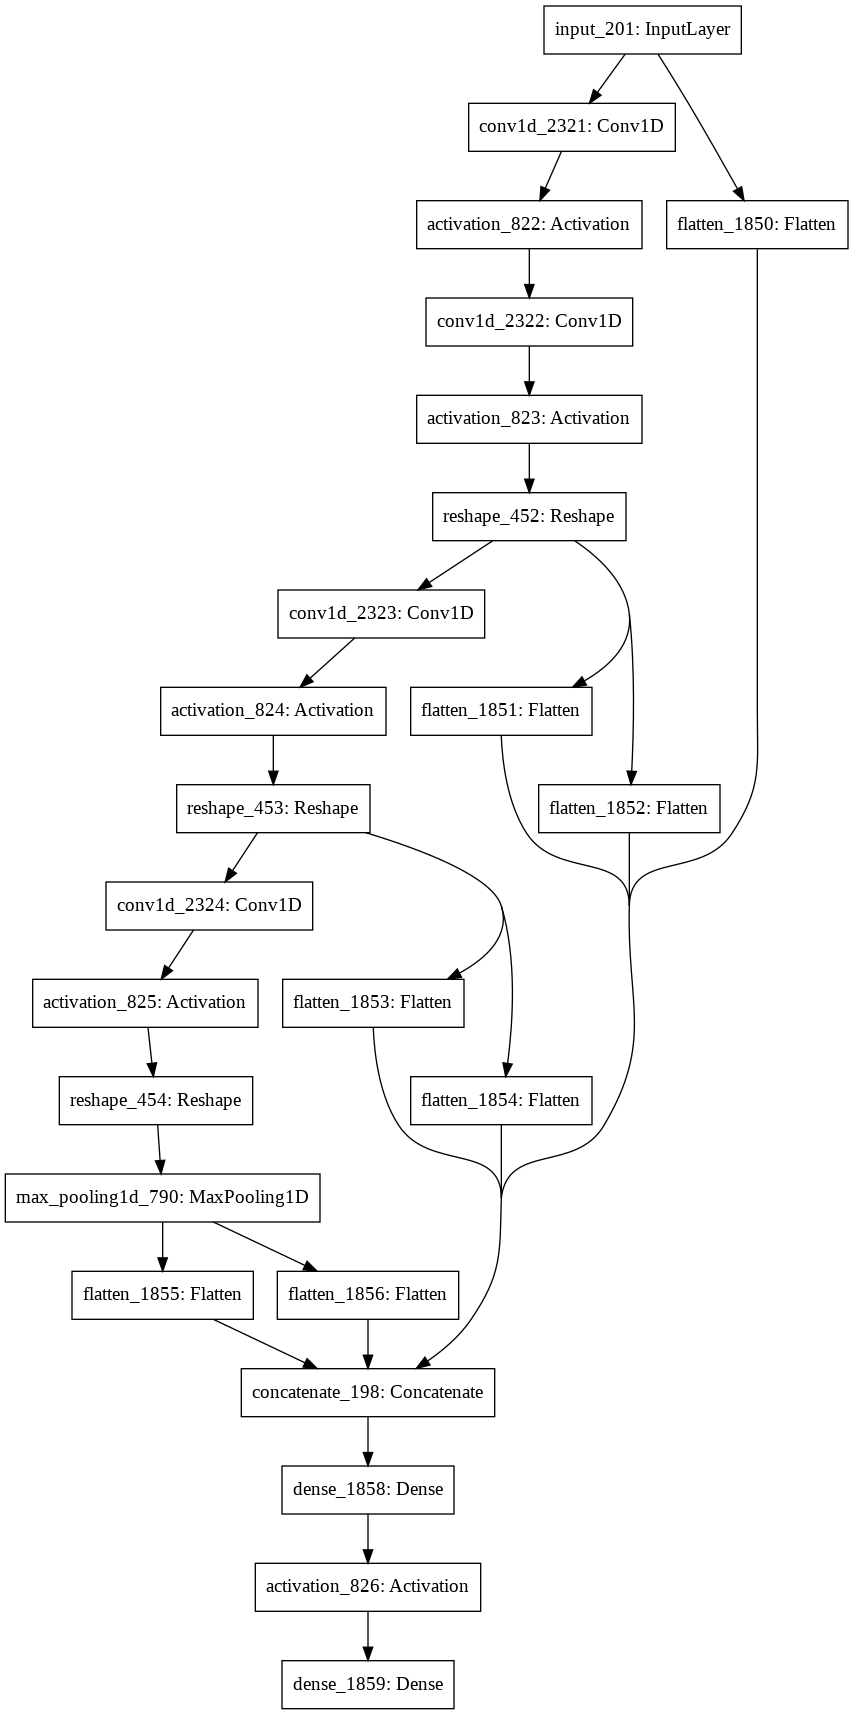

In [118]:
plot_model(model)

###Структуру генетический алгоритм создал, перехожу к обучению:

In [119]:

model.compile(optimizer=Adam(lr=1e-4),loss='mse')
history = model.fit_generator(trainDataGen,epochs=50,validation_data=testDataGen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
37/37 [==============================] - 1s 11ms/step - loss: 0.1796 - val_loss: 0.0273
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0222 - val_loss: 0.0132
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0337
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0158 - val_loss: 0.0120
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0204
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0174 - val_loss: 0.0075
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0071
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0068
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0045
Epoch 10/50
37/37 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0043
Epoch 11/50
37/37 

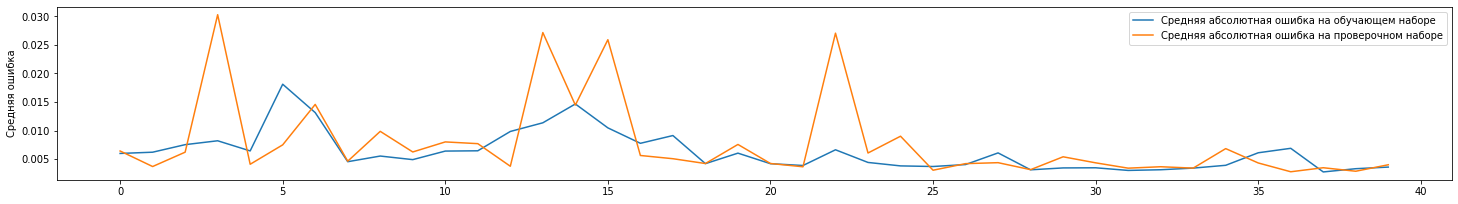

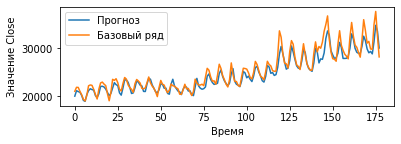

In [123]:
plt.figure(figsize=(25, 7))

plt.subplot(2, 1, 1)
plt.plot(history.history['loss'][10:], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
currModel = model 
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], Scaler) #Прогнозируем данные
showPredict(0, 400, 0, predVal, yValUnscaled)


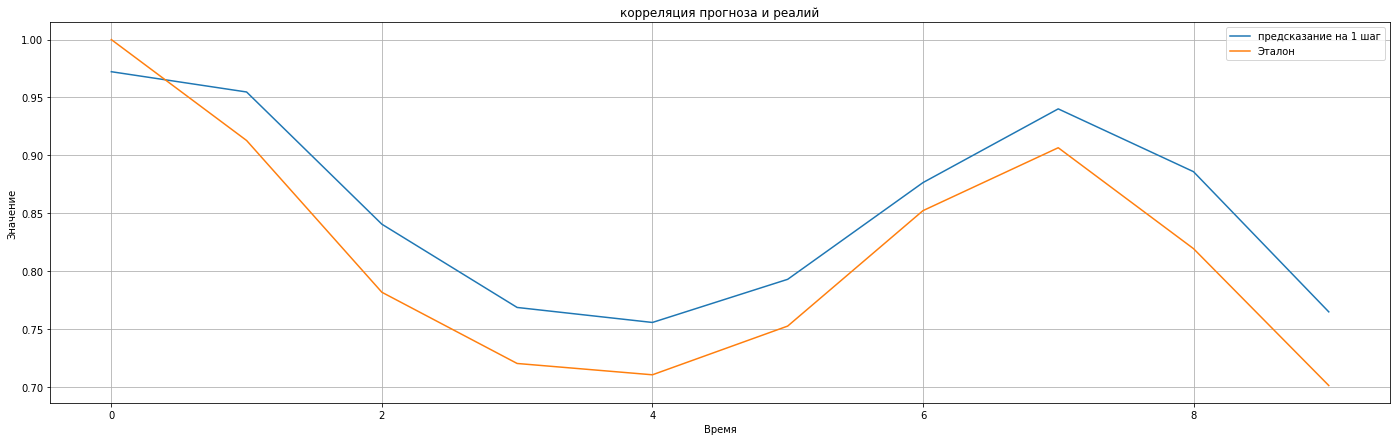

In [126]:
plt.figure(figsize=(24, 7))
plt.grid()
plt.title("корреляция прогноза и реалий")
autoCorr([0], 10, predVal, yValUnscaled)